# Analyze scan location

The purpose of this notebook is to analyze if our ML models work better in certain locations.

We will visualize locations of our data and we will analyze predictions from the ML models.

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from location_utils import (make_polygon, draw_map, draw_polygon, split_by_location, draw_distributions, 
                            LATITUDE_MIN, LATITUDE_MAX, LONGITUDE_MIN, LONGITUDE_MAX, 
                            LONGITUDE_SPLIT1, LONGITUDE_SPLIT2, REPO_DIR)

## Show latitude and longitude on a map

**Prepare data**

To get the CSV, run the following SQL query on cgm-prod:

`SELECT longitude, latitude FROM measure WHERE longitude IS NOT NULL;`


In [2]:
latlong_path = REPO_DIR / "data/latitude-longitude.csv"
df = pd.read_csv(latlong_path, 
                 dtype={"longitude": np.float32, "latitude": np.float32})
df.shape

(56046, 2)

In [3]:
# Remove few points that are not in India
df = df[(LONGITUDE_MIN < df["longitude"]) & (df["longitude"] < LONGITUDE_MAX)]
df.shape

(56031, 2)

**Visualize**

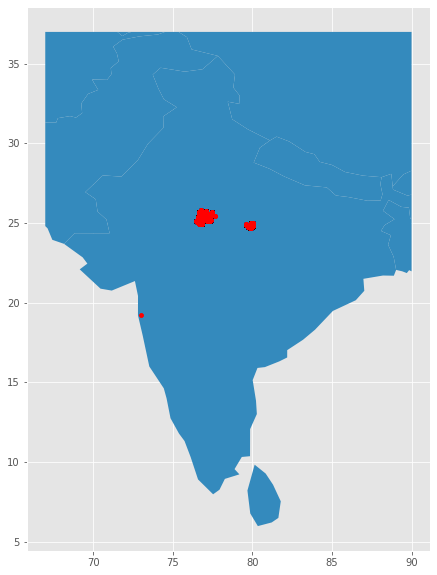

In [4]:
draw_map(df);

In [5]:
# Looks like 
# - Mumbei
# - MP

**Count how many points we have per region**

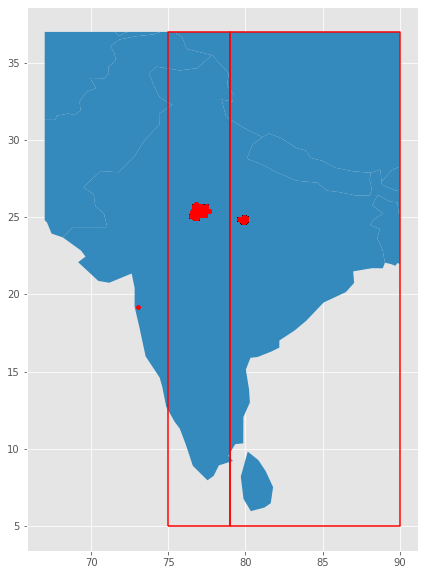

In [6]:
ax = draw_map(df)

# Line out areas
polygon_middle = make_polygon(latitude_min=LATITUDE_MIN, latitude_max=LATITUDE_MAX, longitude_min=LONGITUDE_SPLIT1, longitude_max=LONGITUDE_SPLIT2); draw_polygon(ax, polygon_middle)
polygon_right = make_polygon(latitude_min=LATITUDE_MIN, latitude_max=LATITUDE_MAX, longitude_min=LONGITUDE_SPLIT2, longitude_max=LONGITUDE_MAX); draw_polygon(ax, polygon_right)

In [7]:
# Split points by region
df_left, df_middle, df_right = split_by_location(df)
df_left.shape[0], df_middle.shape[0], df_right.shape[0]

(2, 36348, 19681)

In [8]:
assert sum([df_left.shape[0], df_middle.shape[0], df_right.shape[0]]) == df.shape[0]

## Analyze

To get the CSV, run the following SQL query on cgm-prod:

```
SELECT
m1.type, m2.type, 
mr.model_id, 
m1.longitude,
m1.latitude,
m1.height AS manual_measure_height,
mr.float_value,
mr.key
FROM measure AS m1
INNER JOIN measure AS m2 ON m1.person_id=m2.person_id AND m1.type='manual' AND m2.type!='manual'
INNER JOIN measure_result as mr ON m2.id=mr.measure_id
WHERE mr.model_id LIKE '%height%'
AND m1.longitude IS NOT NULL
AND m2.latitude IS NOT NULL
```

In [9]:
csv_path = REPO_DIR / "data/location_analysis_all_height_models.csv"
df = pd.read_csv(csv_path, dtype={"longitude": np.float32, "latitude": np.float32})
df.shape

(40457, 8)

In [10]:
df['error'] = abs(df['float_value'] - df['manual_measure_height'])

In [11]:
df.head()

,type,type-2,model_id,longitude,latitude,manual_measure_height,float_value,key,error
0,manual,v0.2,20190708-0919_2379-595height,79.600548,24.894823,90.5,83.10539,height_360,7.39461
1,manual,v0.2,20190806-1551_220-55height,79.600548,24.894823,90.5,80.27505,height_360,10.22495
2,manual,v0.2,GAPNet_height_s1,79.904053,24.883871,89.3,90.86953,height_front,1.56953
3,manual,v0.2,GAPNet_height_s1,79.904053,24.883871,89.3,89.89639,height_back,0.59639
4,manual,v0.2,20190708-0919_2379-595height,79.916656,24.893301,73.3,77.48769,height_back,4.18769


In [12]:
list(df['model_id'].unique())

['20190708-0919_2379-595height',
 '20190806-1551_220-55height',
 'GAPNet_height_s1',
 'q3_depthmap_height_run_02',
 'q3_depthmap_height_run_01']

In [13]:
# An interactive part! Yeah! Please choose the model to analyze (wisely)!

# model_name = '20190708-0919_2379-595height'
# model_name = '20190806-1551_220-55height'
model_name = 'GAPNet_height_s1'

In [14]:
df_model = df[df['model_id'] == model_name]; df_model.shape

(26917, 9)

In [15]:
df_left, df_middle, df_right = split_by_location(df_model)
print(df_left.shape[0], df_middle.shape[0], df_right.shape[0])
print(df_middle.error.mean(), df_middle.error.std(), df_middle.shape[0])
print(df_right.error.mean(), df_right.error.std(), df_right.shape[0])

0 12262 14655
3.8268060448540004 4.616536306110189 12262
4.075682283043353 4.559006160650542 14655


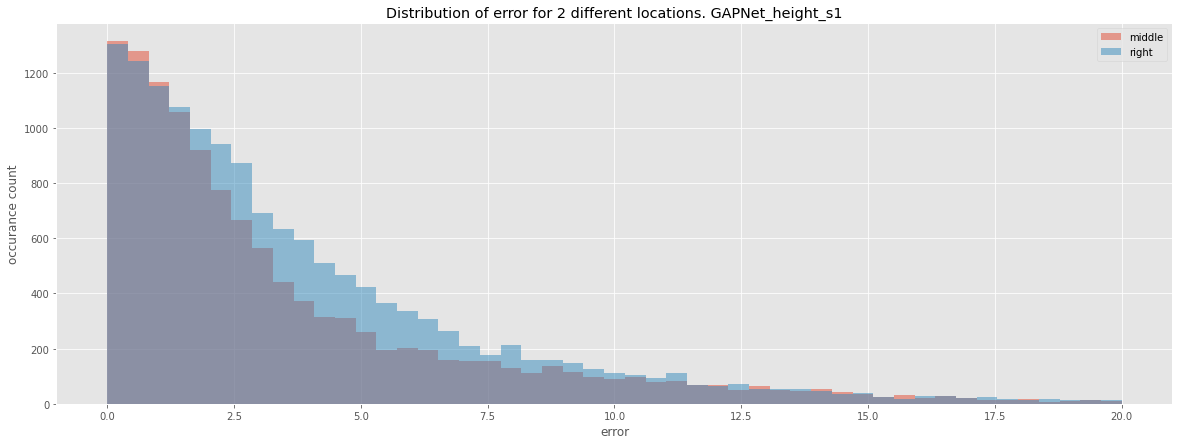

In [16]:
draw_distributions([df_middle.error, df_right.error], labels=['middle', 'right'], caption=model_name)

Future work:
- repeat this experiment when we have new models
    - `q3_depthmap_height_run_01` has 24 rows
    - `20190806-1551_220-55height` has 5333 rows
    - `20190708-0919_2379-595height` has 8159 rows
- repeat when more we have more locations, e.g., 
    - Africa
    - more scans near Mumbei